In [2]:
# Filtering Warnings

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import itertools
import time
from random import random

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
plt.style.use('fivethirtyeight') 

import seaborn as sns   

from tqdm.notebook import trange as notebook_trange
from tqdm import tqdm, trange

In [3]:
# general settings
class CFG:
    data_folder = '../Data/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

In [43]:
# Code dictionaries
# Diagnosis
diagnosis_df = pd.read_csv("../Data/diagnosis.csv")
diagnosis_dict = {diagnosis_df.code.iloc[i]: diagnosis_df.diagnosis.iloc[i] for i in (range(len(diagnosis_df)))}
# Products
products_df = pd.read_csv("../Data/product.csv")
products_dict = {products_df.code.iloc[i]: products_df.products.iloc[i] for i in (range(len(products_df)))}
# Body Part
body_df = pd.read_csv("../Data/body.csv")
body_dict = {body_df.code.iloc[i]: body_df.body_.iloc[i] for i in (range(len(body_df)))}
# Location
loc_dict = pd.read_csv("../Data/loc.csv")
location_dict = {loc_dict.code.iloc[i]: loc_dict.location.iloc[i] for i in (range(len(loc_dict)))}
# Age Group
age_dict = pd.read_csv("../Data/age_group.csv")
age_dict = {age_dict.code.iloc[i]: age_dict.group.iloc[i] for i in (range(len(age_dict)))}
# Disposition
disp_dict = pd.read_csv("../Data/disp.csv")
disp_dict = {disp_dict.code.iloc[i]: disp_dict.disposition.iloc[i] for i in (range(len(disp_dict)))}

In [18]:
series = pd.read_csv(CFG.data_folder + 'preprocessed_children_data.csv')
series.head()

,Treatment_Date,Sex,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Stratum,PSU,Weight,month,year,age_group
0,1/1/2002,1,94,71,1,1,0,3274,V,41,15.0084,132,11,6
1,1/1/2002,1,94,71,1,1,0,3274,V,41,15.0084,168,14,7
2,1/1/2002,1,83,64,1,1,0,1842,V,41,15.0084,48,4,3
3,1/1/2002,1,92,53,1,1,0,827,V,41,15.0084,180,15,7
4,1/1/2002,1,83,58,1,1,0,413,V,41,15.0084,120,10,5


## Simple evaluating whole data

In [19]:
series.rename(columns={"Treatment_Date":"date"},inplace=True)
df = series.copy()
print(f"Our data about {(df.memory_usage(index=True).sum()/(10**6)).round(2)} megabyte.")

Our data about 382.14 megabyte.


In [20]:
series = pd.DataFrame()
series["date"] = df.date.value_counts().index
series["count"] = df.date.value_counts().values
series['date'] = pd.to_datetime(series['date'], format="%m/%d/%Y")
series.sort_values(by="date",ascending=True,inplace=True)
series.reset_index(drop="index",inplace=True)
print(f"Our data about {(series.memory_usage(index=True).sum()/(10**6)).round(2)} megabyte.")
series


Our data about 0.12 megabyte.


,date,count
0,2002-01-01,379
1,2002-01-02,397
2,2002-01-03,392
3,2002-01-04,382
4,2002-01-05,433
...,...,...
7300,2021-12-27,274
7301,2021-12-28,268
7302,2021-12-29,237
7303,2021-12-30,266


<AxesSubplot:xlabel='date'>

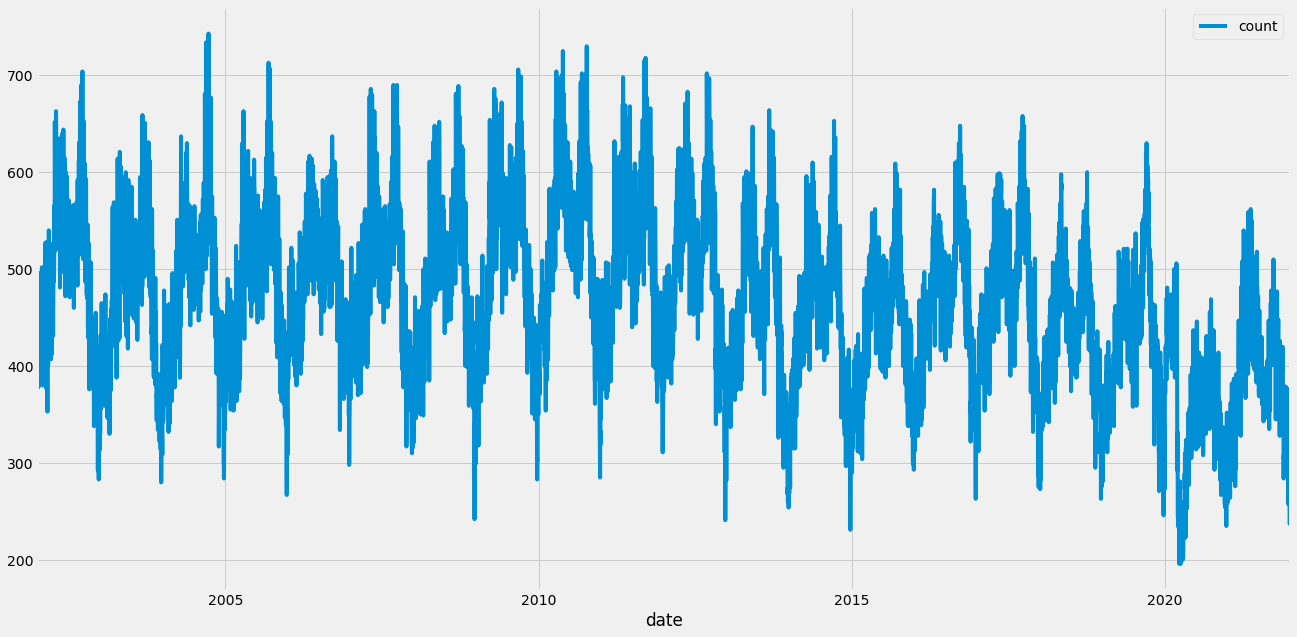

In [21]:
series.set_index('date').plot()


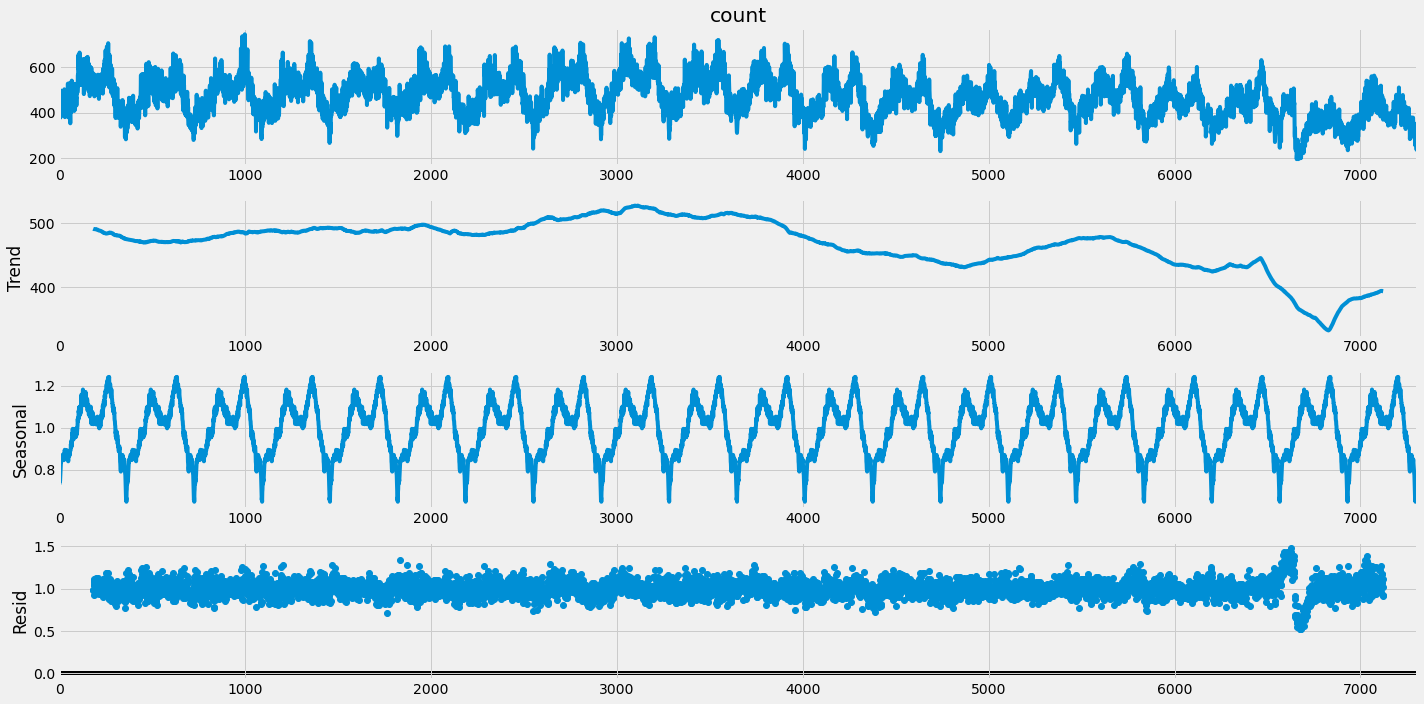

In [22]:
period = 365
decomposition = sm.tsa.seasonal_decompose(series["count"],
                                          period = period, 
                                          model = 'multiplicative') 

decomposition.plot()
plt.show()

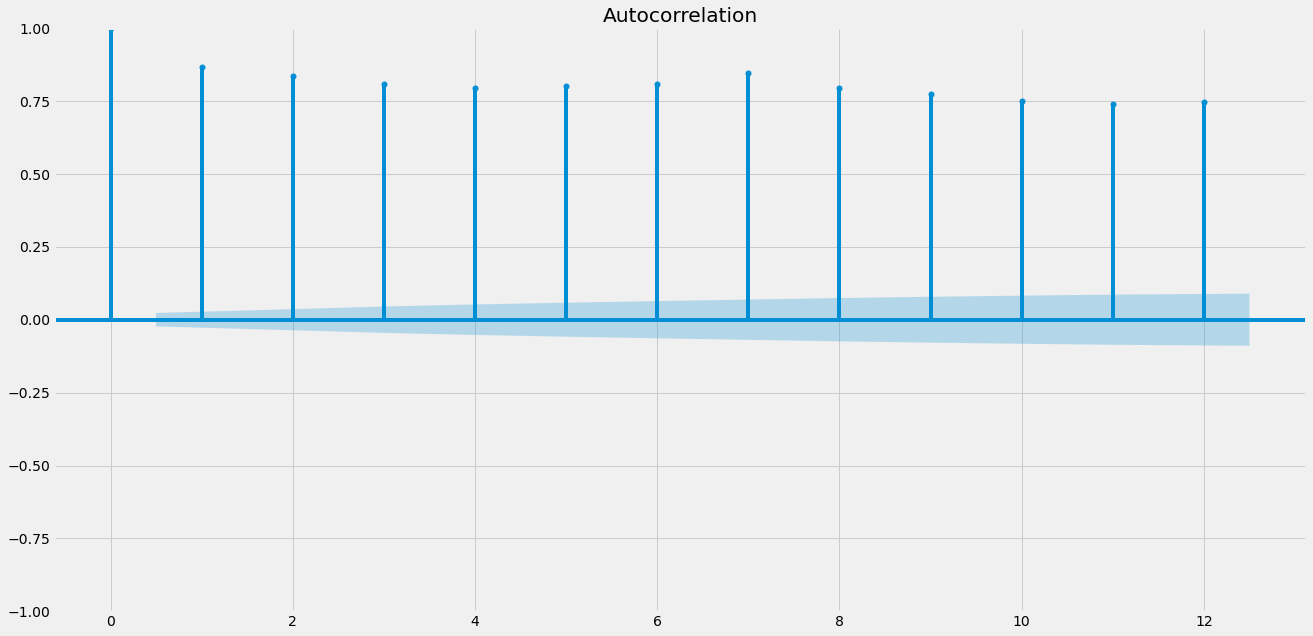

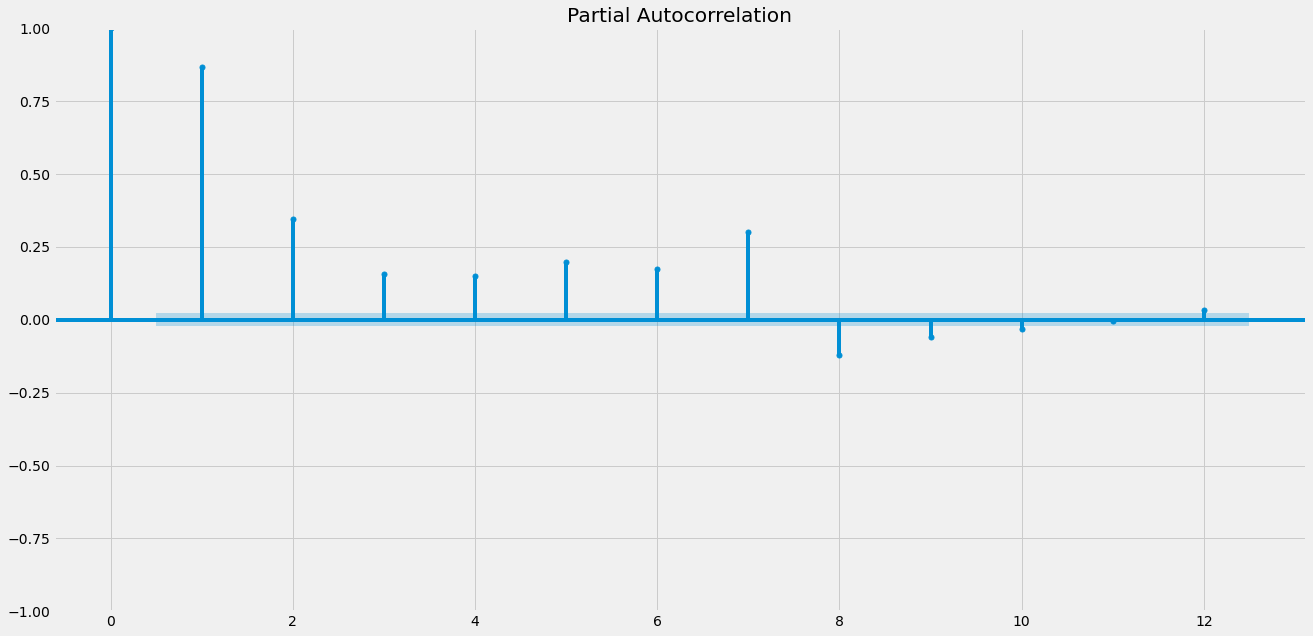

In [23]:
plot_acf(series['count'], lags = 12)
plot_pacf(series['count'], lags = 12)
print()

* ### Augmented Dickey-Fuller unit root test.
* The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [24]:
result = adfuller(series["count"].values)
print('ADF Statistic: %.2f' % result[0])
print('p-value: %.2f' % result[1])
print('usedlag: %.2f' % result[2])
print('nobs: %.2f' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('Result_store: %.2f' % result[5])

ADF Statistic: -7.40
p-value: 0.00
usedlag: 36.00
nobs: 7268.00
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result_store: 71786.82


An important caveat: it is useful to remember that statistical tests do not **accept** a hypothesis - we can only fail to reject it.

Summary:

- above $\alpha$: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.
- below $\alpha$ : Rejects the Null Hypothesis (H0), the data is stationary.

#
Default $\alpha$ is 0.05 (5%)

In [25]:
adf_lag = int(period/2)
result = adfuller(decomposition.trend[adf_lag:-adf_lag])
print('ADF Statistic for Trend: %f' % result[0])
print('p-value: %f' % result[1])
result = adfuller(decomposition.seasonal[adf_lag:-adf_lag])
print('ADF Statistic for Seasonality: %f' % result[0])
print('p-value: %f' % result[1])
result = adfuller(decomposition.resid[adf_lag:-adf_lag])
print('ADF Statistic for Residual: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic for Trend: -0.867273
p-value: 0.798559
ADF Statistic for Seasonality: -11.441019
p-value: 0.000000
ADF Statistic for Residual: -9.452462
p-value: 0.000000


* As we can see, the **hypothesis of non-stationarity** is **non rejected for the trend (p>0.05)component, but not for seasonal (p<0.05) and residual (p<0.05)**. 

* The reason for that is that ADF test check for a very specific form of non-stationarity

* Namely variation in the presence of a linear trend (existence of a single unit root) - while the seasonal component is clearly not stationary (see graph above), it is a qualitatively different kind of behavior.

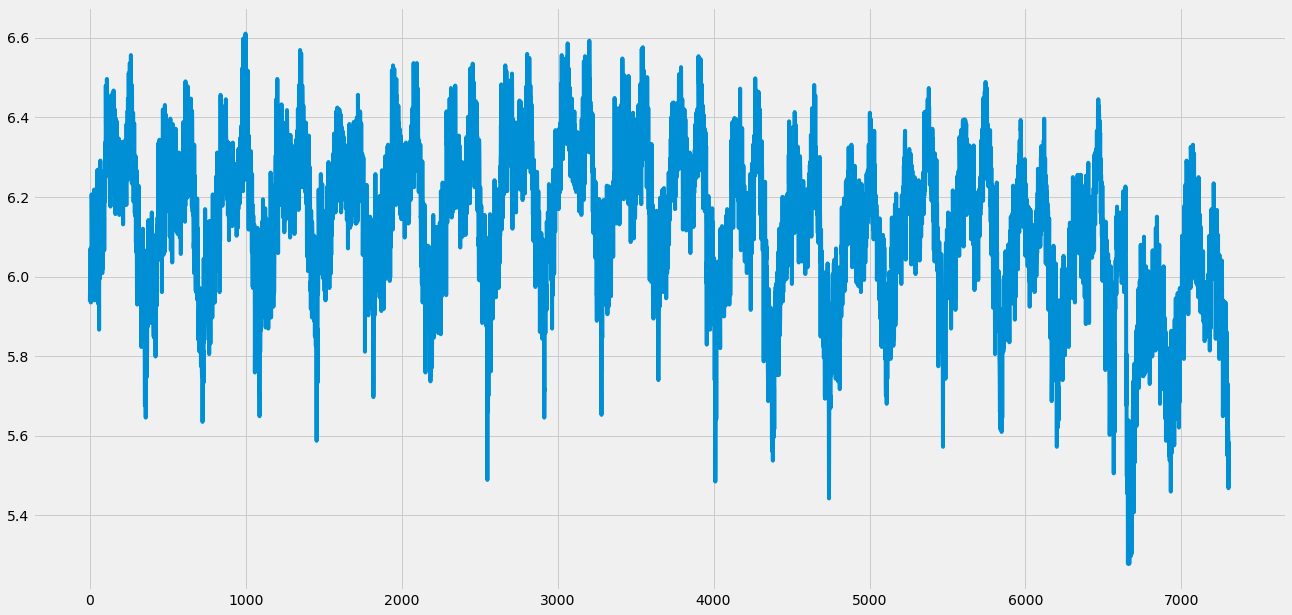

In [26]:
# np.log #

series['count2'] = np.log(series['count'])
series.count2.plot()
plt.show()

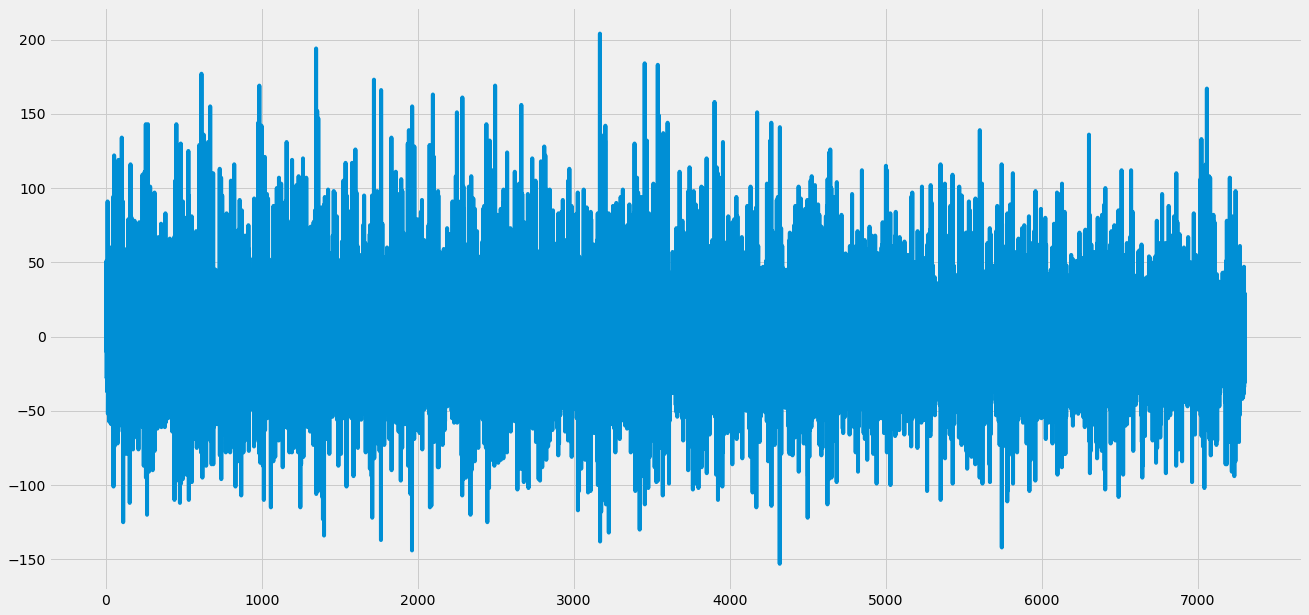

In [27]:
series['count3'] = series['count'].diff()
series.count3.plot()
plt.show()

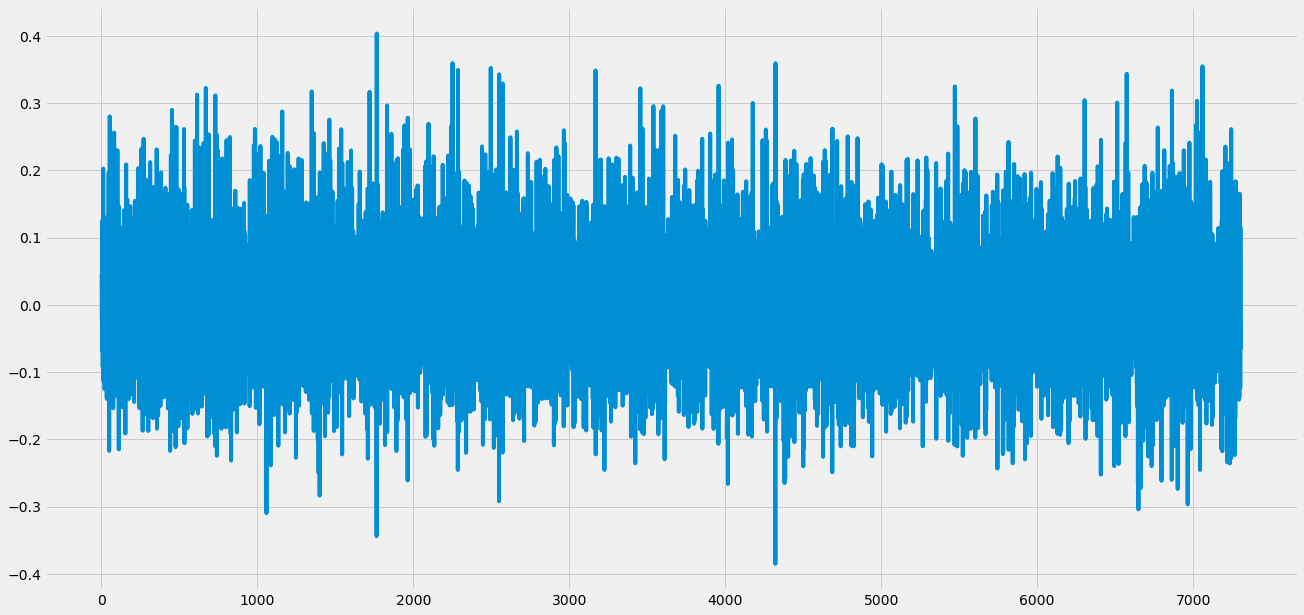

In [28]:
series['count4'] = series['count'].apply(np.log).diff()
series.count4.plot()
plt.show()

In [29]:
result = adfuller(series.count3[182:-182])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.564542
p-value: 0.000000


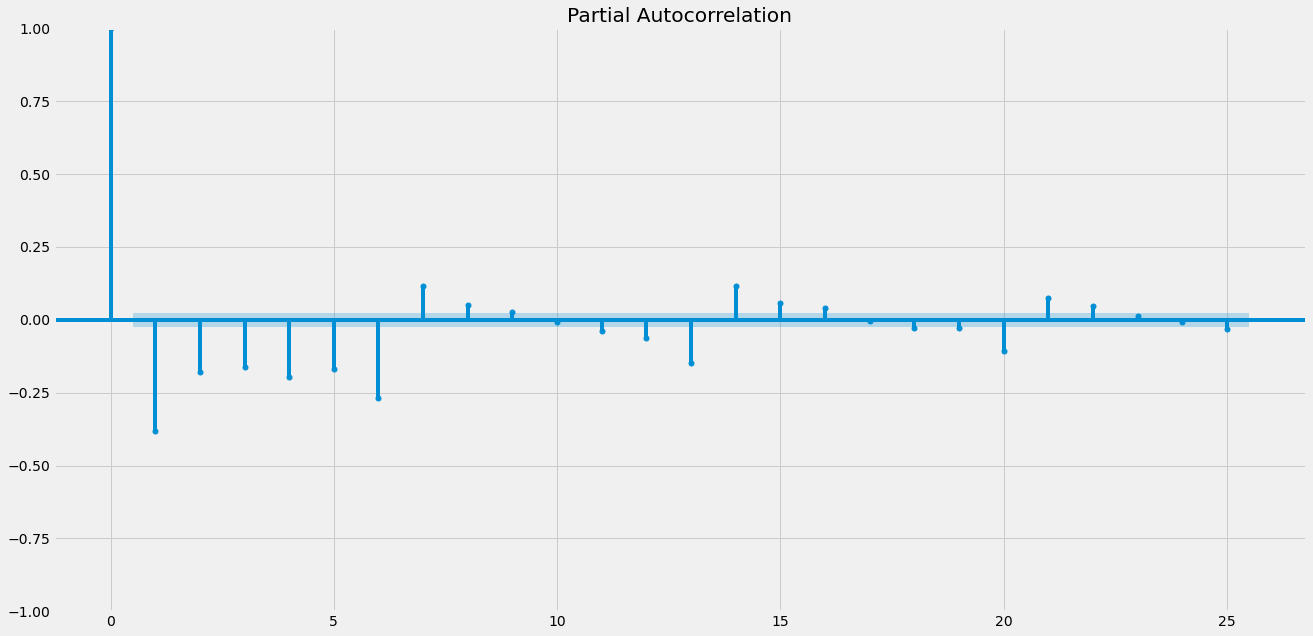

In [30]:
plot_pacf(series.count4[182:-182], lags = 25)
plt.show()

In [31]:
diagnosis_data = df[["date","Diagnosis"]]
diagnosis_data = diagnosis_data[diagnosis_data.Diagnosis.isin(diagnosis_data.Diagnosis.value_counts().head().index)]
diagnosis_data = diagnosis_data.replace({"Diagnosis":diagnosis_dict})

In [32]:
def decomposition_fromdf(df,column_name,variable_name,time_column="date",period=365,model='multiplicative'):

    df = df[df[column_name]==variable_name]
    series = pd.DataFrame()
    series["date"] = df.date.value_counts().index
    series["count"] = df.date.value_counts().values
    series['date'] = pd.to_datetime(series['date'], format="%m/%d/%Y")
    series['date'] = pd.to_datetime(series['date'], unit='s')
    series.sort_values(by="date",ascending=True,inplace=True)
    series.reset_index(drop="index",inplace=True)
    series.reset_index(drop="index",inplace=True)
    series = series.set_index('date')
    series.index = pd.to_datetime(series.index)

    decomposition = sm.tsa.seasonal_decompose(series["count"],
                                              period = period,
                                              model = model) 
    
    return decomposition

* First Case in US :  January 21 2020
* First Day of Stay at Home Order : March 19 2020 (California) 
* End Day of Stay at Home Order : June 15 2021 (California) 

In [110]:
first_case = pd.to_datetime(np.array("01/21/2020"))
first_lockdown = pd.to_datetime(np.array("03/19/2020"))
first_vaccine = pd.to_datetime(np.array("14/12/2020"))
last_lockdown = pd.to_datetime(np.array("15/06/2021"))
first_delta = pd.to_datetime(np.array("01/07/2021"))
first_omicron = pd.to_datetime(np.array("30/11/2021"))


In [100]:
# COVID Data
covid = pd.read_csv("../Data/WHO-COVID-19-global-data.csv")
covid['date'] = pd.to_datetime(covid['Date_reported'], format="%Y-%m-%d")
covid['date'] = pd.to_datetime(covid['date'], unit='s')
covid.drop(columns=["Date_reported","WHO_region","Country"],inplace=True)
covid = covid[(covid.Country_code=="US")]#&(covid.date<='9/9/2021')]
covid

,Country_code,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,date
220124,US,0,0,0,0,2020-01-03
220125,US,0,0,0,0,2020-01-04
220126,US,0,0,0,0,2020-01-05
220127,US,0,0,0,0,2020-01-06
220128,US,0,0,0,0,2020-01-07
...,...,...,...,...,...,...
221093,US,10548,92953690,19,1033207,2022-08-29
221094,US,14927,92968617,30,1033237,2022-08-30
221095,US,91651,93060268,230,1033467,2022-08-31
221096,US,156554,93216822,1252,1034719,2022-09-01


In [160]:
vaccine = pd.read_csv("../Data/vaccine.csv")
vaccine = vaccine[vaccine.Code=="USA"]
vaccine['date'] = pd.to_datetime(vaccine['Day'], format="%Y-%m-%d")
vaccine['date'] = pd.to_datetime(vaccine['date'], unit='s')
# Count for per hundred people
vaccine.rename(columns={"total_vaccinations_per_hundred":"counts"},inplace=True)
vaccine.drop(columns=["Entity","Code","Day"],inplace=True)
vaccine["counts"] = vaccine["counts"].diff()*500000
vaccine = vaccine[~(vaccine.counts.isnull())]
vaccine = vaccine[(vaccine.counts>0)]
vaccine.sort_values(by="date",ascending=True,inplace=True)
vaccine.reset_index(drop="index",inplace=True)
vaccine.reset_index(drop="index",inplace=True)
vaccine = vaccine.set_index('date')
vaccine.index = pd.to_datetime(vaccine.index)

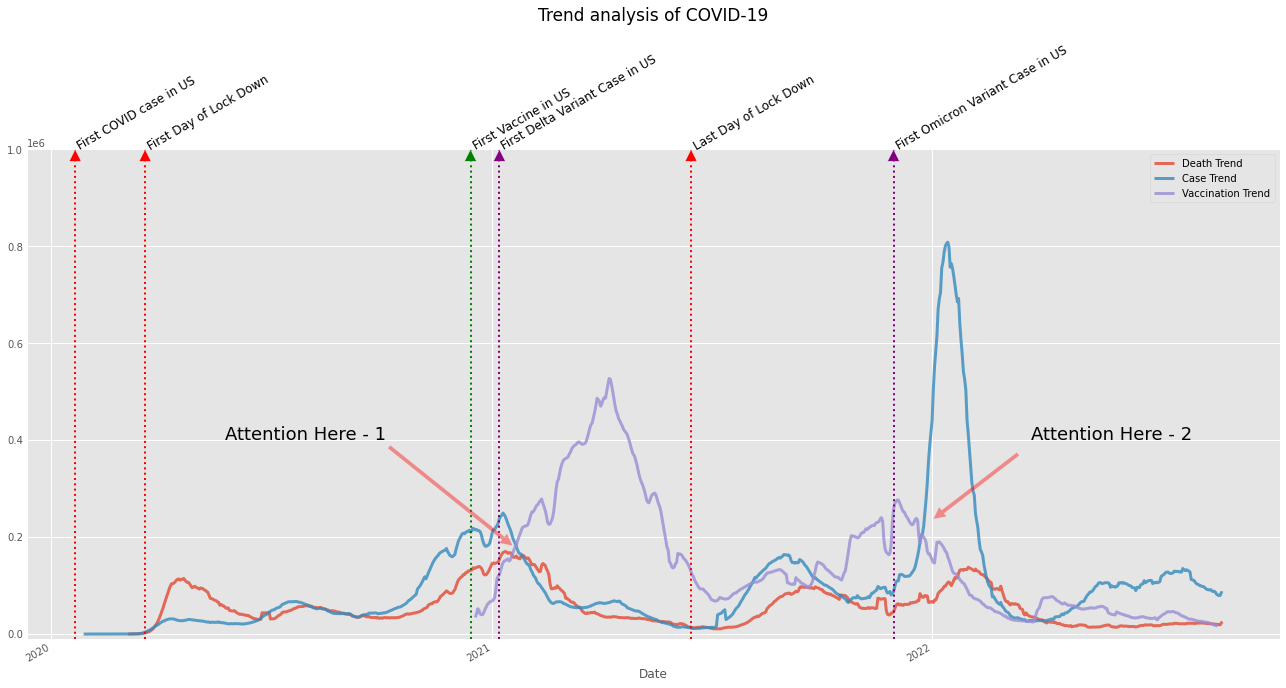

In [229]:
covid_death = covid[["date","New_deaths"]]
covid_death = covid_death[covid_death.New_deaths>0]
covid_death.sort_values(by="date",ascending=True,inplace=True)
covid_death.reset_index(drop="index",inplace=True)
covid_death.reset_index(drop="index",inplace=True)
covid_death = covid_death.set_index('date')
covid_death.index = pd.to_datetime(covid_death.index)


covid_death_decomposition = sm.tsa.seasonal_decompose(covid_death["New_deaths"]*50,
                                                      period = 7,
                                                      model = "multiplicative") 


covid_case = covid[["date","New_cases"]]
covid_case = covid_case[covid_case.New_cases>0]
covid_case.sort_values(by="date",ascending=True,inplace=True)
covid_case.reset_index(drop="index",inplace=True)
covid_case.reset_index(drop="index",inplace=True)
covid_case = covid_case.set_index('date')
covid_case.index = pd.to_datetime(covid_case.index)


covid_case_decomposition = sm.tsa.seasonal_decompose(covid_case["New_cases"],
                                                      period = 7,
                                                      model = "multiplicative") 


vaccine_decomposition = sm.tsa.seasonal_decompose(vaccine["counts"], period = 7, model = "multiplicative") 

covid_death_decomposition.trend.plot(#color ="black", 
                                     label = "Death Trend",
                                     alpha = .8,
                                     linewidth=3)

covid_case_decomposition.trend.plot(#color="red", 
                                    label= "Case Trend",
                                    alpha = .8,
                                    linewidth=3)

vaccine_decomposition.trend.plot(#color = "green", 
                                 label= "Vaccination Trend",
                                 alpha = .8,
                                 linewidth=3)

ax = plt.gca(figsize=(30,15),dpi=1600)
ax.xaxis.set_major_locator(mdates.YearLocator(base = 1, month = 1, day = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.style.use('ggplot')

plt.axvline(x=first_case, color='red',
            alpha = 1, ls=':', lw=2,)

plt.annotate('First COVID case in US',
             xy=(first_case,1000000),
             xytext=(first_case,1000000),
             arrowprops=dict(facecolor='red',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=first_lockdown, color='red',
            alpha = 1, ls=':', lw=2,)                             

plt.annotate('First Day of Lock Down',
             xy=(first_lockdown,1000000),
             xytext=(first_lockdown,1000000),
             arrowprops=dict(facecolor='red',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=first_vaccine, color='green',
            alpha = 1, ls=':', lw=2,)

plt.annotate('First Vaccine in US',
             xy=(first_vaccine,1000000),
             xytext=(first_vaccine,1000000),
             arrowprops=dict(facecolor='green',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=last_lockdown, color='red',
            alpha = 1, ls=':', lw=2,)

plt.annotate('Last Day of Lock Down',
             xy=(last_lockdown,1000000),
             xytext=(last_lockdown,1000000),
             arrowprops=dict(facecolor='red',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=first_delta, color='purple',
            alpha = 1, ls=':', lw=2,)


plt.annotate('First Delta Variant Case in US',
             xy=(first_delta,1000000),
             xytext=(first_delta,1000000),
             arrowprops=dict(facecolor='purple',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)            


plt.axvline(x=first_omicron, color='purple',
            alpha = 1, ls=':', lw=2,)

plt.annotate('First Omicron Variant Case in US',
             xy=(first_omicron,1000000),
             xytext=(first_omicron,1000000),
             arrowprops=dict(facecolor='purple',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)


plt.annotate("Attention Here - 2",
             xy=("2021-12-24",220000),
             xytext=("2022-03-24",400000),
             arrowprops=dict(facecolor='red',
                             shrink=0.1,
                             alpha=.4),
             fontsize = 18,
             rotation = 0)

plt.annotate("Attention Here - 1",
             xy=("2021-01-19",180000),
             xytext=("2020-05-24",400000),
             arrowprops=dict(facecolor='red',
                             shrink=0.01,
                             alpha=.4),
             fontsize = 18,
             rotation = 0,)

             
plt.xlabel("Date")
plt.ylim(-10000,1000000)
plt.gcf().autofmt_xdate() # Rotation
plt.legend( fontsize=10, title_fontsize=25)
plt.title("Trend analysis of COVID-19", y=1.25, fontsize=17)
plt.show()

In [235]:
# subs = pd.read_csv("../submission.csv")
# subs.num_sold = subs.num_sold*1.002
# subs.to_csv("../subssubssubs.csv",index=False)


: 

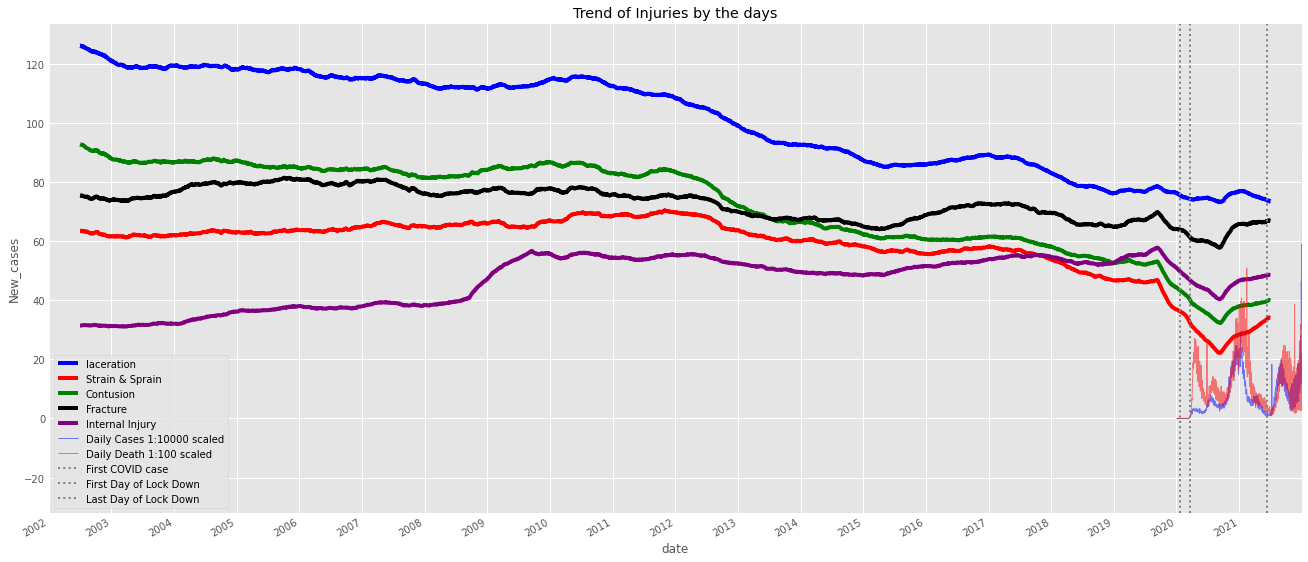

In [194]:
laceration = decomposition_fromdf(diagnosis_data,"Diagnosis"," LACERATION")
strain_sprain = decomposition_fromdf(diagnosis_data,"Diagnosis"," STRAIN, SPRAIN")
contusion = decomposition_fromdf(diagnosis_data,"Diagnosis"," CONTUSIONS, ABR.")
fracture = decomposition_fromdf(diagnosis_data,"Diagnosis"," FRACTURE")
internal = decomposition_fromdf(diagnosis_data,"Diagnosis",' INTERNAL INJURY')

laceration.trend.plot(color="blue",label="laceration")
strain_sprain.trend.plot(color="red",label="Strain & Sprain")
contusion.trend.plot(color="green",label="Contusion")
fracture.trend.plot(color="black",label="Fracture")
internal.trend.plot(color="purple",label="Internal Injury")

sns.lineplot(data=covid,
             x="date",
             y=covid["New_cases"]/10000,
             color="blue",
             alpha=.5,
             linewidth = 1,
             label="Daily Cases 1:10000 scaled")
sns.lineplot(data=covid,
             x="date",
             y=covid["New_deaths"]/100,
             color="red",
             alpha=.5,
             linewidth = 1,
             label="Daily Death 1:100 scaled")

ax = plt.gca(figsize=(25,12))
ax.xaxis.set_major_locator(mdates.YearLocator(base = 1, month = 1, day = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.axvline(x=first_case, color='gray', 
            label='First COVID case',
            alpha = 1, ls=':', lw=2,)
plt.axvline(x=first_lockdown, color='gray',
            label='First Day of Lock Down',
            alpha = 1, ls=':', lw=2,)
plt.axvline(x=last_lockdown, color='gray', 
            label='Last Day of Lock Down',
            alpha = 1, ls=':', lw=2,)

plt.gcf().autofmt_xdate() # Rotation
plt.legend( fontsize=10, title_fontsize=15)
plt.title("Trend of Injuries by the days")
plt.show()

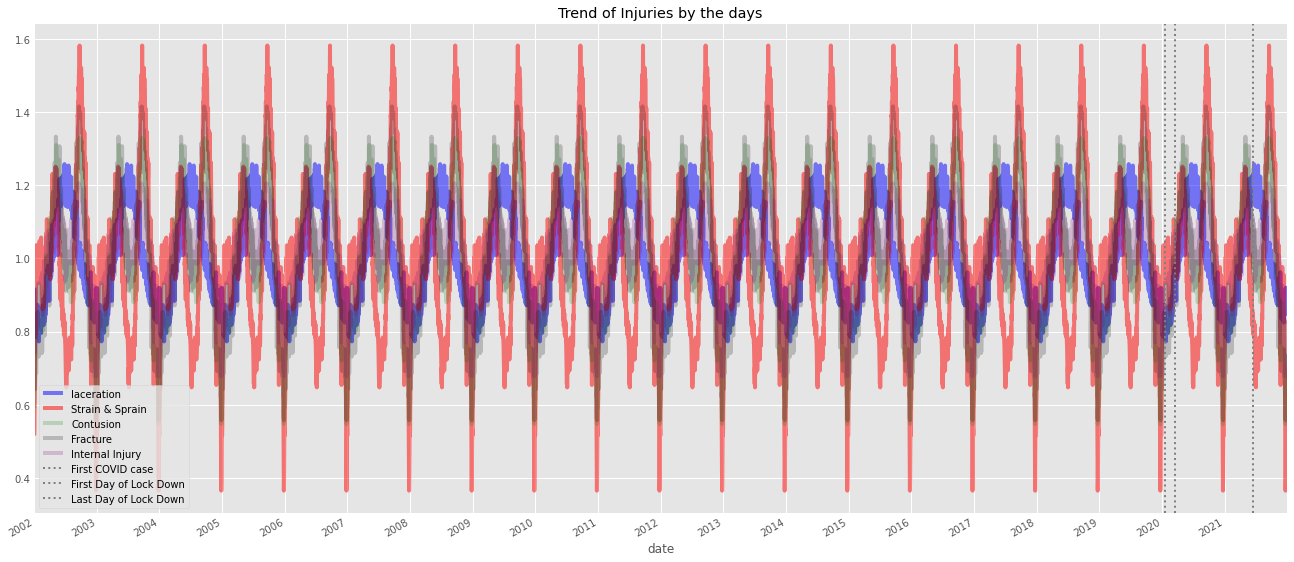

In [195]:
laceration= decomposition_fromdf(diagnosis_data,"Diagnosis"," LACERATION")
strain_sprain= decomposition_fromdf(diagnosis_data,"Diagnosis"," STRAIN, SPRAIN")
contusion = decomposition_fromdf(diagnosis_data,"Diagnosis"," CONTUSIONS, ABR.")
fracture = decomposition_fromdf(diagnosis_data,"Diagnosis"," FRACTURE")
internal = decomposition_fromdf(diagnosis_data,"Diagnosis",' INTERNAL INJURY')

laceration.seasonal.plot(color="blue",label="laceration",alpha=0.5)
strain_sprain.seasonal.plot(color="red",label="Strain & Sprain",alpha=0.5)
contusion.seasonal.plot(color="green",label="Contusion",alpha=0.2)
fracture.seasonal.plot(color="black",label="Fracture",alpha=0.2)
internal.seasonal.plot(color="purple",label="Internal Injury",alpha=0.2)

ax = plt.gca(figsize=(25,12))
ax.xaxis.set_major_locator(mdates.YearLocator(base = 1, month = 1, day = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.axvline(x=first_case, color='gray', 
            label='First COVID case',
            alpha = 1, ls=':', lw=2,)
plt.axvline(x=first_lockdown, color='gray',
            label='First Day of Lock Down',
            alpha = 1, ls=':', lw=2,)
plt.axvline(x=last_lockdown, color='gray', 
            label='Last Day of Lock Down',
            alpha = 1, ls=':', lw=2,)

plt.gcf().autofmt_xdate() # Rotation
plt.legend( fontsize=10, title_fontsize=15)
plt.title("Trend of Injuries by the days")
plt.show()

In [21]:
df_prd = pd.read_csv(CFG.data_folder + 'preprocessed_children_data_product.csv')
df_prd.rename(columns={"Treatment_Date":"date"},inplace=True)

In [24]:

products_data = df_prd[["date","Products"]]
products_data = products_data[products_data.Products.isin(products_data.Products.value_counts().head().index)]
products_data = products_data.replace({"Products":products_dict})
products_data.Products.unique()

array(['STAIRS OR STEPS', 'BASKETBALL, ACTIVITY AND RELATED EQUIPMENT',
       'FOOTBALL (ACTIVITY, APPAREL OR EQUIPMENT)',
       'FLOORS OR FLOORING MATERIALS',
       'BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED'], dtype=object)

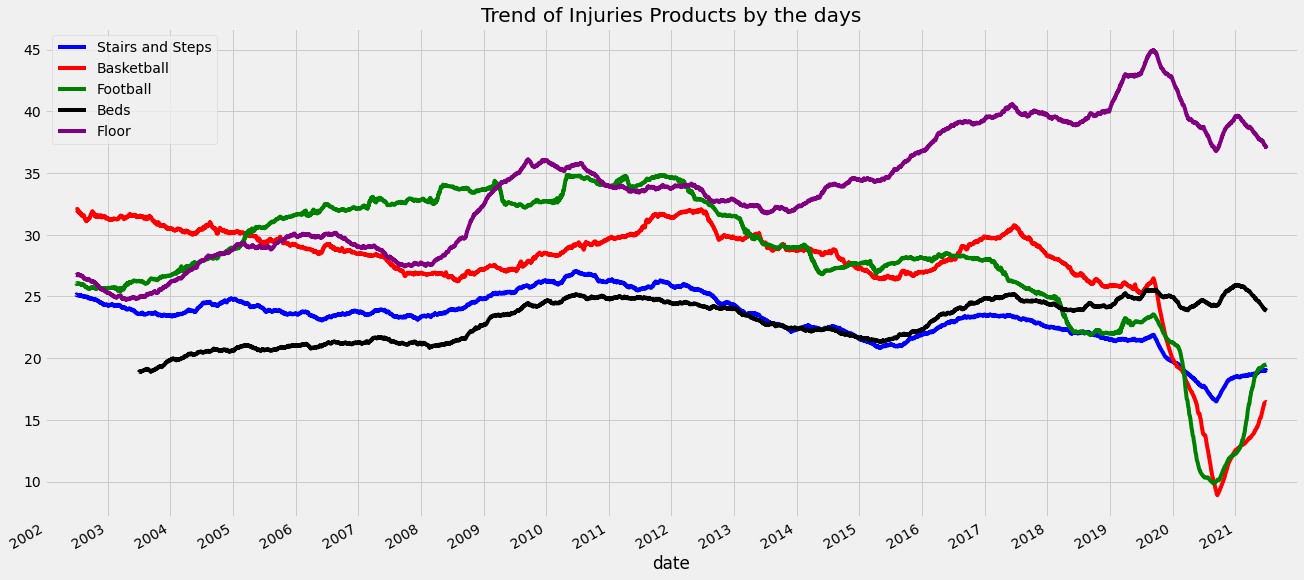

In [25]:
stair_steps = decomposition_fromdf(products_data,"Products",'STAIRS OR STEPS')
basketball = decomposition_fromdf(products_data,"Products",'BASKETBALL, ACTIVITY AND RELATED EQUIPMENT')
football = decomposition_fromdf(products_data,"Products",'FOOTBALL (ACTIVITY, APPAREL OR EQUIPMENT)')
bed = decomposition_fromdf(products_data,"Products",'BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED')
floors = decomposition_fromdf(products_data,"Products",'FLOORS OR FLOORING MATERIALS')

stair_steps.trend.plot(color="blue",label="Stairs and Steps")
basketball.trend.plot(color="red",label="Basketball")
football.trend.plot(color="green",label="Football")
bed.trend.plot(color="black",label="Beds")
floors.trend.plot(color="purple",label="Floor")

ax = plt.gca(figsize=(25,12))
ax.xaxis.set_major_locator(mdates.YearLocator(base = 1, month = 1, day = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend()
plt.title("Trend of Injuries Products by the days")
plt.show()

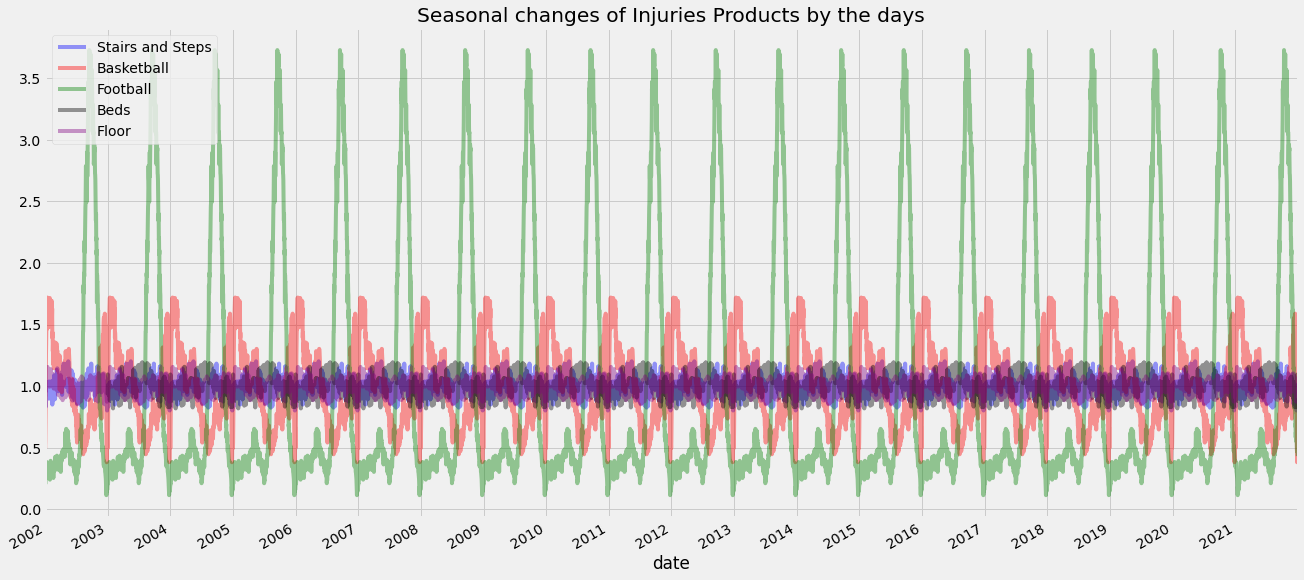

In [26]:
stair_steps.seasonal.plot(color="blue",label="Stairs and Steps",alpha=.4)
basketball.seasonal.plot(color="red",label="Basketball",alpha=.4)
football.seasonal.plot(color="green",label="Football",alpha=.4)
bed.seasonal.plot(color="black",label="Beds",alpha=.4)
floors.seasonal.plot(color="purple",label="Floor",alpha=.4)

ax = plt.gca(figsize=(25,12))
ax.xaxis.set_major_locator(mdates.YearLocator(base = 1, month = 1, day = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend()
plt.title("Seasonal changes of Injuries Products by the days")
plt.show()

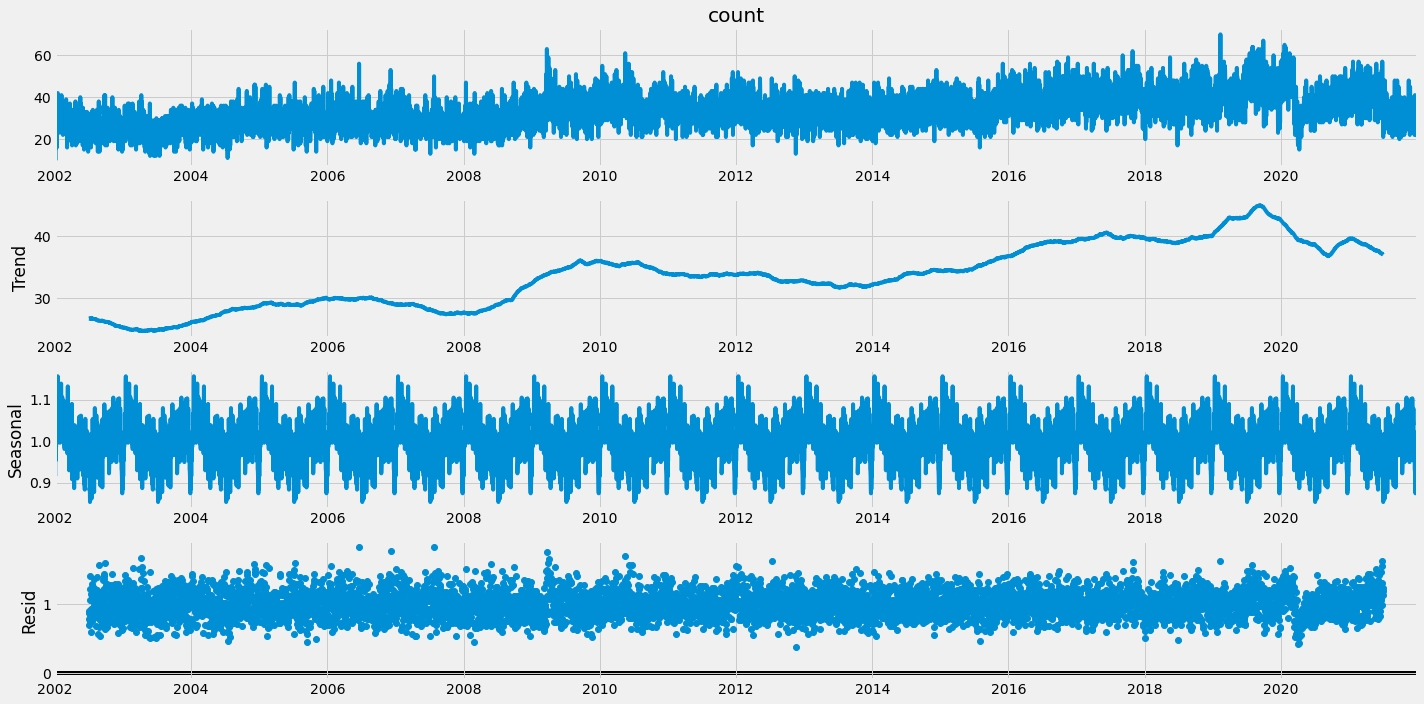

In [30]:
floors.plot()
print()